In [3]:
import os
import numpy as np
import torch

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/emg_dataset/band/clean"
contaminated_dir = "/home/tulgaa/Desktop/emg_dataset/band/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [4]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Delta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Theta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Alpha_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_b

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

# 🔧 Custom Dataset class for 6-band denoising
class EEGDenoiseDataset(torch.utils.data.Dataset):
    def __init__(self, train_data_dict):
        self.bands = list(train_data_dict.keys())
        self.inputs = []
        self.targets = []

        # Stack each band's data into [6, 1024] per sample
        for i in range(len(train_data_dict[self.bands[0]][0])):  # same length for all bands
            input_stack = []
            target_stack = []

            for band in self.bands:
                clean, contaminated = train_data_dict[band]
                input_stack.append(contaminated[i])  # (1024,)
                target_stack.append(clean[i])        # (1024,)

            # Stack to shape (6, 1024)
            self.inputs.append(np.stack(input_stack, axis=0))
            self.targets.append(np.stack(target_stack, axis=0))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        # Inside __getitem__ of EEGDenoiseDataset
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)

# Sum across bands to match the model's output
        y = y.sum(dim=0)

        return x.to(device), y.to(device)
    

# Create dataset and loaders
train_dataset = EEGDenoiseDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ EEGDenoiseDataset and DataLoader ready.")
print(f"🧾 Total training samples: {len(train_dataset)}")



✅ EEGDenoiseDataset and DataLoader ready.
🧾 Total training samples: 36112


In [9]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0).transpose(1, 2)  # Shape: [1, d_model, max_len]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, channels, sequence_length]
        x = x + self.pe[:, :, :x.size(2)]
        return x


class EEGCleanFormer(nn.Module):
    def __init__(self, seq_len=1024, input_channels=6, model_dim=64, num_heads=4, num_layers=2):
        super(EEGCleanFormer, self).__init__()

        # 1️⃣ CNN Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, model_dim, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.LayerNorm([model_dim, seq_len]),
            nn.Conv1d(model_dim, model_dim, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.LayerNorm([model_dim, seq_len]),
        )

        # 2️⃣ Positional Encoding
        self.pos_encoding = PositionalEncoding(d_model=model_dim, max_len=seq_len)

        # 3️⃣ Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4️⃣ Reconstruction Head
        self.decoder = nn.Sequential(
            nn.Conv1d(model_dim, model_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(model_dim, 1, kernel_size=1)
        )

    def forward(self, x):
        # x shape: [batch_size, 6, 1024]
        x = self.encoder(x)  # → [B, model_dim, 1024]
        x = self.pos_encoding(x)  # Add PE
        x = x.permute(0, 2, 1)  # [B, 1024, model_dim] for Transformer
        x = self.transformer(x)  # → [B, 1024, model_dim]
        x = x.permute(0, 2, 1)  # → [B, model_dim, 1024]
        x = self.decoder(x)     # → [B, 1, 1024]
        return x.squeeze(1)     # → [B, 1024]
    
# Instantiate model
model = EEGCleanFormer().to(device)
print("✅ EEGCleanFormer initialized.")


✅ EEGCleanFormer initialized.


In [10]:
import torch.optim as optim
from tqdm import tqdm

# 🔧 Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔂 Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

early_stopping = EarlyStopping()

# 🔁 Training Loop
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"📉 Epoch {epoch+1}: Train Loss = {avg_loss:.6f}")

    early_stopping(avg_loss)
    if early_stopping.stop:
        print("⛔ Early stopping triggered.")
        break

print("✅ Training complete.")


Epoch 1/100:   0%|          | 0/1129 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.41it/s]


📉 Epoch 1: Train Loss = 18380.214328


Epoch 2/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.37it/s]


📉 Epoch 2: Train Loss = 12624.375753


Epoch 3/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.28it/s]


📉 Epoch 3: Train Loss = 11474.012393


Epoch 4/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.26it/s]


📉 Epoch 4: Train Loss = 10780.421341


Epoch 5/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.26it/s]


📉 Epoch 5: Train Loss = 10115.953970


Epoch 6/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 6: Train Loss = 9478.641850


Epoch 7/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 7: Train Loss = 8999.267060


Epoch 8/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.23it/s]


📉 Epoch 8: Train Loss = 8544.378317


Epoch 9/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 9: Train Loss = 8180.442100


Epoch 10/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 10: Train Loss = 7868.433607


Epoch 11/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 11: Train Loss = 7556.621934


Epoch 12/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 12: Train Loss = 7341.097072


Epoch 13/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 13: Train Loss = 7103.094284


Epoch 14/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 14: Train Loss = 6929.233740


Epoch 15/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 15: Train Loss = 6746.533314


Epoch 16/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 16: Train Loss = 6586.856566


Epoch 17/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 17: Train Loss = 6438.985070


Epoch 18/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.23it/s]


📉 Epoch 18: Train Loss = 6318.336299


Epoch 19/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.23it/s]


📉 Epoch 19: Train Loss = 6205.716011


Epoch 20/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 20: Train Loss = 6086.986689


Epoch 21/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 21: Train Loss = 5989.993593


Epoch 22/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 22: Train Loss = 5875.392006


Epoch 23/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 23: Train Loss = 5812.334393


Epoch 24/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 24: Train Loss = 5719.263500


Epoch 25/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 25: Train Loss = 5648.334375


Epoch 26/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 26: Train Loss = 5567.202821


Epoch 27/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 27: Train Loss = 5506.692608


Epoch 28/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 28: Train Loss = 5435.224395


Epoch 29/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 29: Train Loss = 5394.315876


Epoch 30/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 30: Train Loss = 5316.585446


Epoch 31/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.30it/s]


📉 Epoch 31: Train Loss = 5286.070011


Epoch 32/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 32: Train Loss = 5225.570101


Epoch 33/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 33: Train Loss = 5182.352462


Epoch 34/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 34: Train Loss = 5135.923513


Epoch 35/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 35: Train Loss = 5080.882684


Epoch 36/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.23it/s]


📉 Epoch 36: Train Loss = 5062.978730


Epoch 37/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 37: Train Loss = 5007.009030


Epoch 38/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 38: Train Loss = 4981.667636


Epoch 39/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 39: Train Loss = 4939.824118


Epoch 40/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 40: Train Loss = 4926.181142


Epoch 41/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 41: Train Loss = 4877.845830


Epoch 42/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 42: Train Loss = 4849.891549


Epoch 43/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 43: Train Loss = 4819.669216


Epoch 44/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 44: Train Loss = 4792.144547


Epoch 45/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 45: Train Loss = 4778.277976


Epoch 46/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 46: Train Loss = 4738.780606


Epoch 47/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 47: Train Loss = 4731.332766


Epoch 48/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 48: Train Loss = 4688.943073


Epoch 49/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 49: Train Loss = 4679.871618


Epoch 50/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 50: Train Loss = 4645.749328


Epoch 51/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 51: Train Loss = 4633.111542


Epoch 52/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 52: Train Loss = 4615.083825


Epoch 53/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 53: Train Loss = 4592.135632


Epoch 54/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 54: Train Loss = 4575.939300


Epoch 55/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.16it/s]


📉 Epoch 55: Train Loss = 4549.310783


Epoch 56/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 56: Train Loss = 4536.034572


Epoch 57/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 57: Train Loss = 4515.288416


Epoch 58/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 58: Train Loss = 4494.719263


Epoch 59/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 59: Train Loss = 4484.132910


Epoch 60/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 60: Train Loss = 4469.825276


Epoch 61/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.16it/s]


📉 Epoch 61: Train Loss = 4456.196168


Epoch 62/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 62: Train Loss = 4432.468130


Epoch 63/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 63: Train Loss = 4422.664354


Epoch 64/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 64: Train Loss = 4412.027005


Epoch 65/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 65: Train Loss = 4392.799740


Epoch 66/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 66: Train Loss = 4372.819798


Epoch 67/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 67: Train Loss = 4368.787639


Epoch 68/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 68: Train Loss = 4346.472958


Epoch 69/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.23it/s]


📉 Epoch 69: Train Loss = 4340.195739


Epoch 70/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.16it/s]


📉 Epoch 70: Train Loss = 4324.113807


Epoch 71/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 71: Train Loss = 4313.843001


Epoch 72/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 72: Train Loss = 4309.251298


Epoch 73/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 73: Train Loss = 4290.173757


Epoch 74/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 74: Train Loss = 4275.769698


Epoch 75/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 75: Train Loss = 4271.555142


Epoch 76/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 76: Train Loss = 4258.071737


Epoch 77/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 77: Train Loss = 4246.689145


Epoch 78/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 78: Train Loss = 4236.191540


Epoch 79/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 79: Train Loss = 4238.581455


Epoch 80/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 80: Train Loss = 4212.851994


Epoch 81/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 81: Train Loss = 4206.871896


Epoch 82/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.16it/s]


📉 Epoch 82: Train Loss = 4198.640210


Epoch 83/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 83: Train Loss = 4186.849242


Epoch 84/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 84: Train Loss = 4183.865167


Epoch 85/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 85: Train Loss = 4171.591028


Epoch 86/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]


📉 Epoch 86: Train Loss = 4168.794016


Epoch 87/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 87: Train Loss = 4150.742431


Epoch 88/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 88: Train Loss = 4154.767020


Epoch 89/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.21it/s]


📉 Epoch 89: Train Loss = 4129.863246


Epoch 90/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.16it/s]


📉 Epoch 90: Train Loss = 4125.071197


Epoch 91/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.22it/s]


📉 Epoch 91: Train Loss = 4119.326331


Epoch 92/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 92: Train Loss = 4114.023130


Epoch 93/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 93: Train Loss = 4104.603772


Epoch 94/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.15it/s]


📉 Epoch 94: Train Loss = 4101.605741


Epoch 95/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.15it/s]


📉 Epoch 95: Train Loss = 4095.831850


Epoch 96/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.17it/s]


📉 Epoch 96: Train Loss = 4083.790006


Epoch 97/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 97: Train Loss = 4071.904323


Epoch 98/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.18it/s]


📉 Epoch 98: Train Loss = 4066.884702


Epoch 99/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.20it/s]


📉 Epoch 99: Train Loss = 4062.202077


Epoch 100/100: 100%|██████████| 1129/1129 [00:58<00:00, 19.19it/s]

📉 Epoch 100: Train Loss = 4059.072606
✅ Training complete.


✅ Avg RRMSE-t: 0.3098
✅ Avg RRMSE-s: 0.2224
✅ Avg CC     : 0.9525


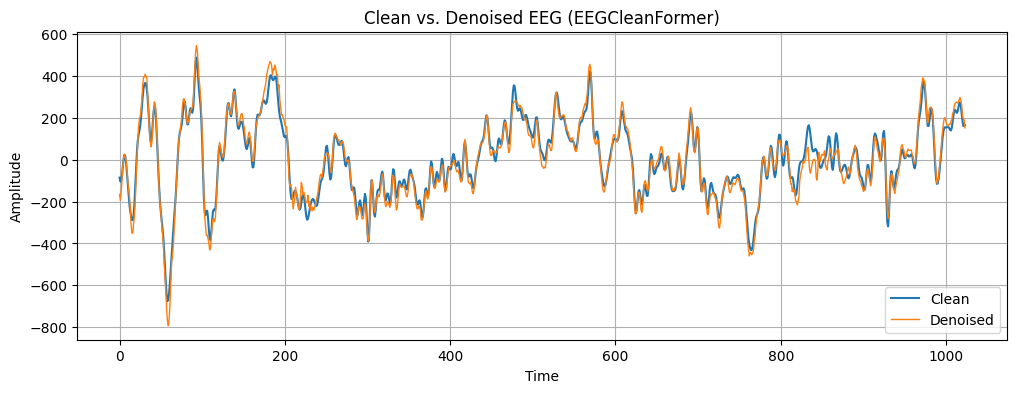

In [11]:
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import pearsonr

# ⚙️ Evaluation Functions
def rrmse(pred, true):
    return np.sqrt(np.mean((pred - true) ** 2)) / np.sqrt(np.mean(true ** 2))

def rrmse_freq(pred, true):
    pred_fft = np.abs(fft(pred))
    true_fft = np.abs(fft(true))
    return np.sqrt(np.mean((pred_fft - true_fft) ** 2)) / np.sqrt(np.mean(true_fft ** 2))

def correlation(pred, true):
    return pearsonr(pred, true)[0]

# 🔍 Evaluate on test set
model.eval()
rrmse_t_list, rrmse_s_list, cc_list = [], [], []

with torch.no_grad():
    for band in bands:
        test_clean, test_contaminated, snr_labels_test = test_data[band]
        break  # use one band just to get correct shape

    for i in range(len(test_clean)):  # Full test set
        # Create 6-band input
        band_stack = []
        for band in bands:
            test_clean_b, test_contaminated_b, _ = test_data[band]
            band_stack.append(test_contaminated_b[i])
        input_tensor = torch.tensor(np.stack(band_stack, axis=0), dtype=torch.float32).unsqueeze(0).to(device)

        target = np.stack([test_data[band][0][i] for band in bands], axis=0).sum(axis=0)  # Sum of clean bands
        denoised = model(input_tensor).cpu().numpy().flatten()

        # Compute metrics
        rrmse_t_list.append(rrmse(denoised, target))
        rrmse_s_list.append(rrmse_freq(denoised, target))
        cc_list.append(correlation(denoised, target))

# 📊 Print averages
print(f"✅ Avg RRMSE-t: {np.mean(rrmse_t_list):.4f}")
print(f"✅ Avg RRMSE-s: {np.mean(rrmse_s_list):.4f}")
print(f"✅ Avg CC     : {np.mean(cc_list):.4f}")

# 📈 Plot example result
plt.figure(figsize=(12, 4))
plt.plot(target, label="Clean", linewidth=1.5)
plt.plot(denoised, label="Denoised", linewidth=1)
plt.title("Clean vs. Denoised EEG (EEGCleanFormer)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
snr_levels = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

def compute_ts_metric(rrmse_t, rrmse_s):
    return 10 * np.log10(1 / (rrmse_t * rrmse_s))

model.eval()
results_by_snr = {}

with torch.no_grad():
    for snr in snr_levels:
        rrmse_t_list, rrmse_s_list, cc_list = [], [], []

        # Loop through test set
        for i in range(len(test_data["Delta_band"][2])):
            snr_label = test_data["Delta_band"][2][i]
            if snr_label != snr:
                continue

            # Build 6-band input
            band_input = []
            for band in bands:
                band_input.append(test_data[band][1][i])  # contaminated
            x = torch.tensor(np.stack(band_input), dtype=torch.float32).unsqueeze(0).to(device)

            # Sum of clean bands
            target = np.stack([test_data[band][0][i] for band in bands]).sum(axis=0)
            denoised = model(x).cpu().numpy().flatten()

            # Metrics
            rrmse_t_list.append(rrmse(denoised, target))
            rrmse_s_list.append(rrmse_freq(denoised, target))
            cc_list.append(correlation(denoised, target))

        if rrmse_t_list:  # Avoid divide-by-zero if SNR not found
            avg_rrmse_t = np.mean(rrmse_t_list)
            avg_rrmse_s = np.mean(rrmse_s_list)
            avg_cc = np.mean(cc_list)
            ts_metric = compute_ts_metric(avg_rrmse_t, avg_rrmse_s)

            results_by_snr[snr] = (avg_rrmse_t, avg_rrmse_s, avg_cc, ts_metric)

            print(f"✅ SNR {snr}: RRMSE-T = {avg_rrmse_t:.4f}, RRMSE-S = {avg_rrmse_s:.4f}, CC = {avg_cc:.4f}, T&S Metric = {ts_metric:.4f} dB")
        else:
            print(f"⚠️ No test samples for SNR {snr}")


✅ SNR -7: RRMSE-T = 0.3978, RRMSE-S = 0.2730, CC = 0.9199, T&S Metric = 9.6423 dB
✅ SNR -6: RRMSE-T = 0.3631, RRMSE-S = 0.2546, CC = 0.9334, T&S Metric = 10.3407 dB
✅ SNR -5: RRMSE-T = 0.3319, RRMSE-S = 0.2358, CC = 0.9450, T&S Metric = 11.0649 dB
✅ SNR -4: RRMSE-T = 0.3151, RRMSE-S = 0.2266, CC = 0.9515, T&S Metric = 11.4621 dB
✅ SNR -3: RRMSE-T = 0.3012, RRMSE-S = 0.2184, CC = 0.9561, T&S Metric = 11.8194 dB
✅ SNR -2: RRMSE-T = 0.2907, RRMSE-S = 0.2118, CC = 0.9598, T&S Metric = 12.1071 dB
✅ SNR -1: RRMSE-T = 0.2790, RRMSE-S = 0.2040, CC = 0.9634, T&S Metric = 12.4479 dB
✅ SNR 0: RRMSE-T = 0.2763, RRMSE-S = 0.2025, CC = 0.9642, T&S Metric = 12.5214 dB
✅ SNR 1: RRMSE-T = 0.2708, RRMSE-S = 0.1986, CC = 0.9657, T&S Metric = 12.6942 dB
✅ SNR 2: RRMSE-T = 0.2722, RRMSE-S = 0.1987, CC = 0.9657, T&S Metric = 12.6686 dB


📊 Found 903 test samples for SNR Level -5


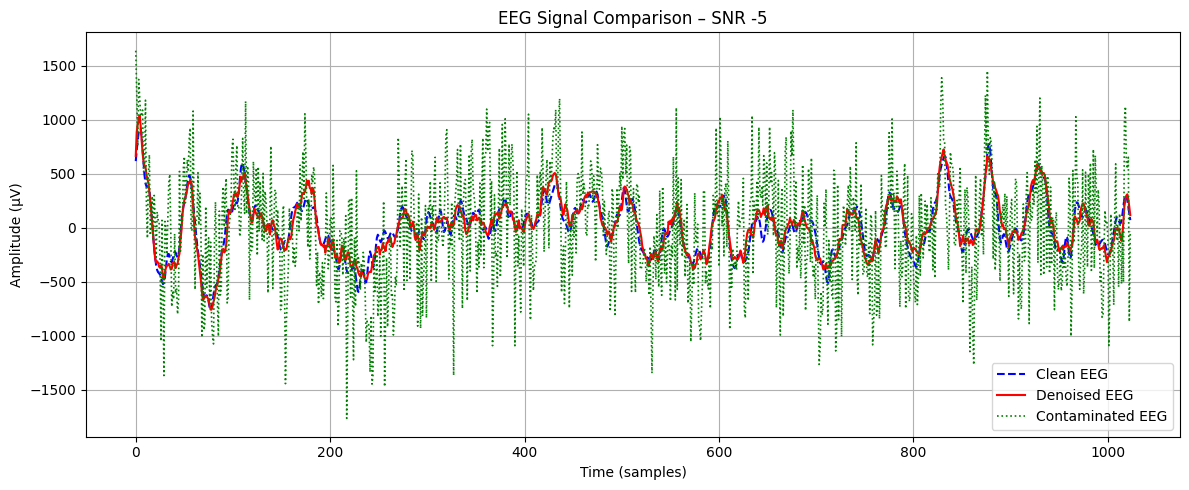

In [13]:
import matplotlib.pyplot as plt

# 📍 Select SNR level
snr_level = -5

# ✅ Extract SNR labels for Delta band (same for all bands)
snr_labels_test_int = np.array(test_data["Delta_band"][2])  # Already converted earlier

# ✅ Find indices of test samples for that SNR
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    first_segment_idx = snr_indices[0]

    # ✅ Reconstruct 6-band input and clean + contaminated
    input_stack = np.stack([test_data[band][1][first_segment_idx] for band in bands], axis=0)  # contaminated
    clean_stack = np.stack([test_data[band][0][first_segment_idx] for band in bands], axis=0)

    contaminated_segment = np.sum(input_stack, axis=0)
    clean_segment = np.sum(clean_stack, axis=0)

    # ✅ Run model
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_stack, dtype=torch.float32).unsqueeze(0).to(device)
        denoised_segment = model(input_tensor).cpu().numpy().flatten()

    # ✅ Plot
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", color="blue", linewidth=1.5, linestyle="dashed")
    plt.plot(denoised_segment, label="Denoised EEG", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG", color="green", linestyle="dotted", linewidth=1.2)
    
    plt.title(f"EEG Signal Comparison – SNR {snr_level}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (μV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 663.6604614257812)
(1, 884.7276000976562)
(2, 953.6361083984375)
(3, 986.4661254882812)
(4, 1037.9281005859375)
(5, 943.6934204101562)
(6, 823.7791748046875)
(7, 690.8291625976562)
(8, 615.2589721679688)
(9, 570.9774169921875)
(10, 562.1986694335938)
(11, 488.41192626953125)
(12, 451.7413635253906)
(13, 414.9388732910156)
(14, 336.2551574707031)
(15, 236.12132263183594)
(16, 128.9300079345703)
(17, 33.52935791015625)
(18, -91.52735137939453)
(19, -204.2413787841797)
(20, -288.06072998046875)
(21, -323.9023742675781)
(22, -310.573486328125)
(23, -325.683349609375)
(24, -361.7734069824219)
(25, -366.6115417480469)
(26, -348.12451171875)
(27, -367.9444885253906)
(28, -470.7046203613281)
(29, -481.0221862792969)
(30, -416.106201171875)
(31, -372.04998779296875)
(32, -351.0013427734375)
(33, -347.15386962890625)
(34, -334.5017395019531)
(35, -357.7481689453125)
(36, -386.8510437011719)
(37, -381.594970703125)
(38, -328.85015869140625)
(39, -320.759033203125

In [15]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

clean EEG Plotting Points:
(0, 615.6761337234491)
(1, 717.743876925784)
(2, 799.6842321117309)
(3, 882.4032627117512)
(4, 917.0758980840789)
(5, 917.9972357990938)
(6, 849.1111234537042)
(7, 739.9367386732771)
(8, 603.3199869951318)
(9, 486.20022005640425)
(10, 410.02636747417193)
(11, 382.3766165761935)
(12, 381.9492865143415)
(13, 377.58003340389)
(14, 341.5427661474394)
(15, 265.4448863513407)
(16, 156.96735249187483)
(17, 34.802047654274624)
(18, -85.44941028003518)
(19, -192.49905757380674)
(20, -281.77424474888534)
(21, -348.47530090609933)
(22, -391.2450859816875)
(23, -411.92044334171123)
(24, -421.857623464543)
(25, -434.8408740077363)
(26, -461.4857328145644)
(27, -496.4074562414044)
(28, -521.3376091352245)
(29, -512.2488200009743)
(30, -459.6623840747161)
(31, -375.5575623752697)
(32, -292.92806215932745)
(33, -244.00668382154223)
(34, -243.57571953112225)
(35, -276.51438721464547)
(36, -311.21039405740225)
(37, -317.81331766456054)
(38, -291.10333498120394)
(39, -249.55582